In [1]:
%pylab inline
%config InlineBackend.figure_format = 'svg'

Populating the interactive namespace from numpy and matplotlib


In [2]:
import arviz as az
from astropy.cosmology import Planck15
import astropy.units as u
import bilby
import emcee
import h5py
import lal
import lalsimulation as ls

In [3]:
bilby.__version__

'1.1.1: (UNCLEAN) 2d549842 2021-04-23 01:29:30 -0400'

In [4]:
def next_pow_2(x):
    p = 1.0
    while p < x:
        p *= 2
    return p

In [24]:
with h5py.File('../mocks/observations.h5', 'r') as f:
    N = f['truth/m1_source'].shape[0]
    i = randint(N)
    
    m1 = f['truth/m1_source'][i]
    q = f['truth/q'][i]
    z = f['truth/z'][i]
    
    d = Planck15.luminosity_distance(z).to(u.Mpc).value
    
duration = next_pow_2(ls.SimInspiralChirpTimeBound(10, (1+z)*m1*lal.MSUN_SI, (1+z)*m1*q*lal.MSUN_SI, 0, 0) + 1)
sampling_frequency = 1024.

outdir = 'CBCTest'
label = 'CBCTest'
bilby.core.utils.setup_logger(outdir=outdir, label=label)

theta_jn = arccos(np.random.uniform(low=-1, high=1))
psi = np.random.uniform(low=0, high=2*pi)
ra = np.random.uniform(low=0, high=2*pi)
dec = arcsin(np.random.uniform(low=-1, high=1))
geocent_time = np.random.uniform(low=0, high=24.0*3600.0)
phase = np.random.uniform(low=0, high=2*pi)

injection_parameters = dict(
    mass_1=m1*(1+z), mass_2=m1*q*(1+z), a_1=0.0, a_2=0.0, tilt_1=0.0, tilt_2=0.0,
    phi_12=0.0, phi_jl=0.0, luminosity_distance=d, theta_jn=theta_jn, psi=psi,
    phase=phase, geocent_time=1126259642.413 + geocent_time, ra=ra, dec=dec)

waveform_arguments = dict(waveform_approximant='IMRPhenomPv3',
                          reference_frequency=10., minimum_frequency=10.)

waveform_generator = bilby.gw.WaveformGenerator(
    duration=duration, sampling_frequency=sampling_frequency,
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
    parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
    waveform_arguments=waveform_arguments)

H1 = bilby.gw.detector.get_empty_interferometer('H1')
H1.power_spectral_density = bilby.gw.detector.PowerSpectralDensity(asd_file="../noisecurves/AplusDesign.txt")

L1 = bilby.gw.detector.get_empty_interferometer('L1')
L1.power_spectral_density = bilby.gw.detector.PowerSpectralDensity(asd_file="../noisecurves/AplusDesign.txt")

V1 = bilby.gw.detector.get_empty_interferometer('V1')
V1.power_spectral_density = bilby.gw.detector.PowerSpectralDensity(asd_file="../noisecurves/avirgo_O5high_NEW.txt")

ifos = bilby.gw.detector.InterferometerList([H1, L1, V1])
ifos.set_strain_data_from_power_spectral_densities(
          sampling_frequency=sampling_frequency, duration=duration,
          start_time=injection_parameters['geocent_time'] - (duration-1))

ifos.inject_signal(waveform_generator=waveform_generator,
                   parameters=injection_parameters)

mc = m1*(1+z)*q**(3/5)/(1+q)**(1/5)

priors = bilby.gw.prior.BBHPriorDict()
priors.pop('mass_1')
priors.pop('mass_2')

priors.pop('theta_jn')
priors.pop('a_1')
priors.pop('a_2')
priors.pop('tilt_1')
priors.pop('tilt_2')
priors.pop('phi_12')
priors.pop('phi_jl')

priors['theta_jn'] = 0.0
priors['a_1'] = 0.0
priors['a_2'] = 0.0
priors['tilt_1'] = 0.0
priors['tilt_2'] = 0.0
priors['phi_12'] = 0.0
priors['phi_jl'] = 0.0

priors['chirp_mass'] = bilby.prior.Uniform(
    name='chirp_mass', latex_label='$M$', minimum=next_pow_2(mc/4), maximum=next_pow_2(2*mc),
    unit='$M_{\\odot}$')

priors['mass_ratio'] = bilby.prior.Uniform(
    name='mass_ratio', latex_label='$q$', minimum=0.1, maximum=1.0)

priors['geocent_time'] = bilby.core.prior.Uniform(
    minimum=injection_parameters['geocent_time'] - 0.1,
    maximum=injection_parameters['geocent_time'] + 0.1,
    name='geocent_time', latex_label='$t_c$', unit='$s$')

priors['luminosity_distance'] = bilby.gw.prior.UniformSourceFrame(
    minimum=100.0, maximum=30000,  
    name='luminosity_distance', latex_label='$d_L$', unit='Mpc')

likelihood = bilby.gw.likelihood.GravitationalWaveTransient(
    interferometers=ifos, waveform_generator=waveform_generator, priors=priors,
    distance_marginalization=True, phase_marginalization=True, time_marginalization=True)

print('Signal duration = {:.1f} s'.format(ls.SimInspiralChirpTimeBound(10, (1+z)*m1*lal.MSUN_SI, (1+z)*m1*q*lal.MSUN_SI, 0, 0)))
print('Data segment duration = {:.1f} s'.format(duration))
print('SNR = {:.1f}'.format(sqrt(ifos.meta_data['H1']['optimal_SNR']**2 + ifos.meta_data['L1']['optimal_SNR']**2 + ifos.meta_data['V1']['optimal_SNR'])))
print('mc = {:.1f} MSun'.format(mc))

21:36 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
21:36 bilby INFO    : Injected signal in H1:
21:36 bilby INFO    :   optimal SNR = 6.78
21:36 bilby INFO    :   matched filter SNR = 6.25-0.37j
21:36 bilby INFO    :   mass_1 = 74.47279342451505
21:36 bilby INFO    :   mass_2 = 69.20056761790778
21:36 bilby INFO    :   a_1 = 0.0
21:36 bilby INFO    :   a_2 = 0.0
21:36 bilby INFO    :   tilt_1 = 0.0
21:36 bilby INFO    :   tilt_2 = 0.0
21:36 bilby INFO    :   phi_12 = 0.0
21:36 bilby INFO    :   phi_jl = 0.0
21:36 bilby INFO    :   luminosity_distance = 7068.243438245261
21:36 bilby INFO    :   theta_jn = 0.7348244635938955
21:36 bilby INFO    :   psi = 2.3489059512788097
21:36 bilby INFO    :   phase = 5.241812172179567
21:36 bilby INFO    :   geocent_time = 1126290060.856735
21:36 bilby INFO

Signal duration = 1.9 s
Data segment duration = 4.0 s
SNR = 10.6
mc = 62.5 MSun


In [25]:
result = bilby.run_sampler(
    likelihood=likelihood, priors=priors,
    injection_parameters=injection_parameters, outdir=outdir,
    label=label,
    sampler='dynesty',
    conversion_function=bilby.gw.conversion.generate_all_bbh_parameters, 
    nact=1)

21:36 bilby INFO    : Running for label 'CBCTest', output will be saved to 'CBCTest'
21:36 bilby INFO    : Using lal version 7.1.2
21:36 bilby INFO    : Using lal git version Branch: None;Tag: lal-v7.1.2;Id: c21902de2364e911fab0c5fa47ea5b954fbced73;;Builder: Adam Mercer <adam.mercer@ligo.org>;Repository status: CLEAN: All modifications committed
21:36 bilby INFO    : Using lalsimulation version 2.5.1
21:36 bilby INFO    : Using lalsimulation git version Branch: None;Tag: lalsimulation-v2.5.1;Id: bdbbfabd0f14ce7fcb8d574f1a07e911e62c85b5;;Builder: Adam Mercer <adam.mercer@ligo.org>;Repository status: CLEAN: All modifications committed
21:36 bilby INFO    : Search parameters:
21:36 bilby INFO    :   mass_ratio = Uniform(minimum=0.1, maximum=1.0, name='mass_ratio', latex_label='$q$', unit=None, boundary=None)
21:36 bilby INFO    :   chirp_mass = Uniform(minimum=16.0, maximum=128.0, name='chirp_mass', latex_label='$M$', unit='$M_{\\odot}$', boundary=None)
21:36 bilby INFO    :   dec = Cosin

0it [00:00, ?it/s]

21:36 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 1800, 'nlive': 1000, 'first_update': None, 'walks': 100, 'npdim': None, 'rstate': None, 'queue_size': 1, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 600, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x14968f160>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 1, 'adapt_tscale': 100}
21:36 bilby INFO    : Checkpoint every check_point_delta_t = 600s
21:36 bilby INFO    : Using dynesty version 1.1
21:36 bilby INFO    : Using the bilby-impl

22:06 bilby INFO    : Sampling time: 0:29:11.692995
22:06 bilby INFO    : Reconstructing marginalised parameters.


  0%|          | 0/12905 [00:00<?, ?it/s]

22:17 bilby INFO    : Generating sky frame parameters.


  0%|          | 0/12905 [00:00<?, ?it/s]

22:18 bilby INFO    : Computing SNRs for every sample.


  0%|          | 0/12905 [00:00<?, ?it/s]

22:20 bilby INFO    : Summary of results:
nsamples: 12905
ln_noise_evidence: -5899.833
ln_evidence: -5862.887 +/-  0.125
ln_bayes_factor: 36.947 +/-  0.125



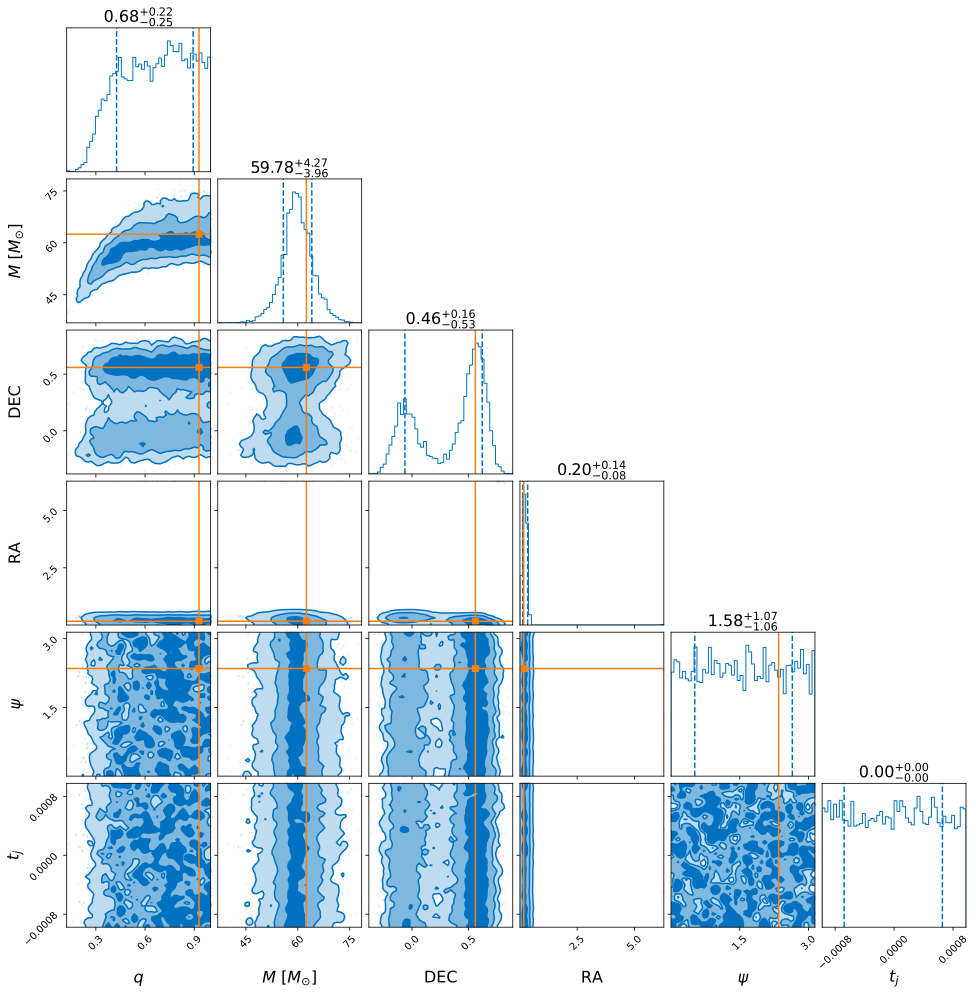

In [26]:
result.plot_corner()

22:45 bilby INFO    : Plotting luminosity_distance marginal distribution


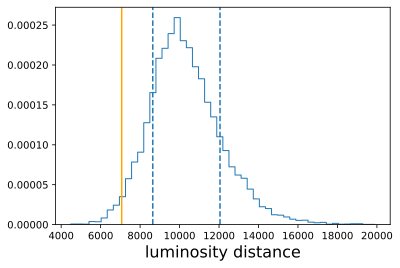

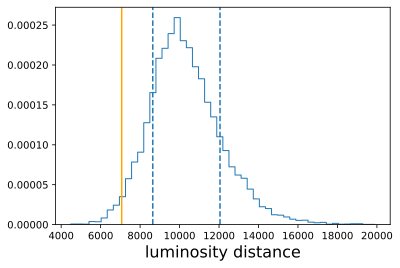

In [27]:
result.plot_single_density("luminosity_distance", save=False, truth=injection_parameters['luminosity_distance'])

22:45 bilby INFO    : Plotting chirp_mass marginal distribution


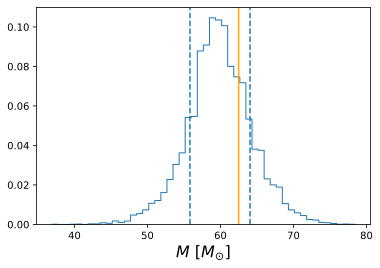

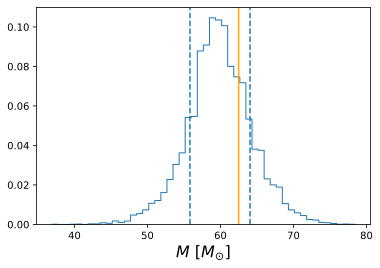

In [28]:
result.plot_single_density("chirp_mass", save=False, truth=m1*q**(3/5)/(1+q)**(1/5)*(1+z))

In [29]:
#with open('snr_uncertainty.csv', 'w') as f:
#    f.write('SNR,sigma_log_mc,sigma_eta,sigma_log_dl\n')

In [30]:
with open('snr_uncertainty.csv', 'a') as f:
    p = result.posterior
    SNR = mean(sqrt(mean(p['H1_optimal_snr']**2 + p['L1_optimal_snr']**2 + p['V1_optimal_snr']**2)))
    sigma_log_mc = std(log(p['chirp_mass']))
    sigma_eta = std(p['mass_ratio']**(3/5)/(1+p['mass_ratio'])**(1/5))
    sigma_log_dl = std(log(p['luminosity_distance']))
    
    f.write('\n{:g},{:g},{:g},{:g}'.format(SNR, sigma_log_mc, sigma_eta, sigma_log_dl))